In [3]:
%load_ext autoreload
%autoreload 2
import plotly.io as pio
pio.renderers.default='notebook'

import os
import numpy as np

In [2]:
# def projection(pt_infront, calib, fisheye):
#     a, b = pt_infront[0,:]/pt_infront[2,:], pt_infront[1,:]/pt_infront[2,:]
#     if fisheye:
#         k1, k2, k3, k4, k5 = -3.77171309e-01,  1.90805099e+00,  1.49424193e-03, -5.44006658e-03, -6.22743876e+00
#         r = (a**2 + b**2)**0.5
#         theta = np.arctan(r)
#         thed = theta*(1+k1*theta**2+k2*theta**4+k3*theta**6+k4*theta**8 +k5*theta**10)
#         x_,y_ = thed/r*a, thed/r*b
#         u = 1.84852409e+03*(x_+calib['LCAM']['alpha_c']*y_) + 7.96736294e+02
#         v = 1.83675470e+03*y_ + 6.89480920e+02
#     else:
#         u = 1.84852409e+03*a + 7.96736294e+02
#         v = 1.83675470e+03*b + 6.89480920e+02
#     return u, v

In [3]:
def projection(pt_infront, calib, fisheye):
    a, b = pt_infront[0,:]/pt_infront[2,:], pt_infront[1,:]/pt_infront[2,:]
    if fisheye:
        k1, k2, k3, k4 = calib['LCAM']['k'][0], calib['LCAM']['k'][1],calib['LCAM']['k'][2],calib['LCAM']['k'][3]
        r = (a**2 + b**2)**0.5
        theta = np.arctan(r)
        thed = theta*(1+k1*theta**2+k2*theta**4+k3*theta**6+k4*theta**8)
        x_,y_ = thed/r*a, thed/r*b
        u = calib['LCAM']['fx']*(x_+calib['LCAM']['alpha_c']*y_) + calib['LCAM']['cx']
        v = calib['LCAM']['fy']*y_ + calib['LCAM']['cy']
    else:
        u = calib['LCAM']['fx']*a + calib['LCAM']['cx']
        v = calib['LCAM']['fy']*b + calib['LCAM']['cy']
    return u, v

In [1]:
import glob
root = '/home/xc429/Junan/calib_test/data2/cache'

In [5]:
import json
with open('calibration.json') as f:
    calib = json.load(f)
    
Rot = calib['203_to_LCAM']['Rot_203']
T = calib['203_to_LCAM']['T_203']
Rot = np.asarray(Rot)
T = np.asarray(T)
# Rot = np.array([[ 0.7624643 , -0.64634549, -0.02976072],
#        [-0.04196313, -0.00349823, -0.99911304],
#        [ 0.6456681 ,  0.76303687, -0.02978996]])
# T = np.array([[-0.07946306],
#        [-0.08448351],
#        [ 0.0470211 ]])

In [4]:
img_dir = os.path.join(root,'camera_front_left_60fov/*')
img_files = glob.glob(img_dir)
img_ts = [os.path.split(path)[1] for path in img_files]
img_ts = [int(t.split('.')[0]) for t in img_ts]
assert len(img_ts)==len(img_files)
print("how many img files: ", len(img_files))

lidar_dir = os.path.join(root,'lidar_203/data/*')
lidar_files = glob.glob(lidar_dir)
lidar_ts = [int(os.path.split(path)[1]) for path in lidar_files]
assert len(lidar_ts)==len(lidar_files)
print("how many lidar files: ", len(lidar_files))

how many img files:  55930
how many lidar files:  18479


In [28]:
def load_pcl_from_bin5(bin_file_path):
    bin_pcd = np.fromfile(bin_file_path,dtype=np.float32)
    points = bin_pcd.reshape(-1,5)
#     print('diff', points[-1,4]-points[0,4])
    return points[:,:3],points[:,3],points[:,4]

def getLastUnixHour_array(time_list):
    array_cam = np.sort(np.asarray(time_list,dtype=np.float))
    last_unix_hour = int(array_cam[0]-(array_cam[0] % (1E6*3600)))
#     print('last hour',last_unix_hour)
    return last_unix_hour


idx = 16000#15000#11500#11000#8000#12000 #16000 #10755#16000
pts, intensity, times = load_pcl_from_bin5(lidar_files[idx])
os.path.split(lidar_files[idx])[1]
last_unix_hour = getLastUnixHour_array(lidar_ts)
times_for_each_point= times+last_unix_hour
np.mean(times_for_each_point)
print(last_unix_hour)
print(times_for_each_point[0])

1607108400000000
1607112277437440.0


/home/xc429/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



In [29]:
import cv2
import matplotlib.pyplot as plt
from matplotlib import cm

im = cv2.imread(img_files[idx])
m,n = im.shape[0], im.shape[1]

pts_cam = np.dot(Rot,pts.T) + T.reshape(-1,1) 
pts_cam = pts_cam.T

idx_infront = pts_cam[:,2] >= 0
pts_infront = pts_cam[idx_infront,:]
times_infront = times_for_each_point[idx_infront]

u,v = projection(pts_infront.T, calib, fisheye=True)

flag_within_img = (u>0)*(u<n)*(v>0)*(v<m)
pts_infront = pts_infront[flag_within_img]
times_infront = times_infront[flag_within_img]
u = u[flag_within_img]
v= v[flag_within_img]
print(len(pts_infront))
time_lidar = np.mean(times_infront)
time_lidar

2912


1607112277512622.8

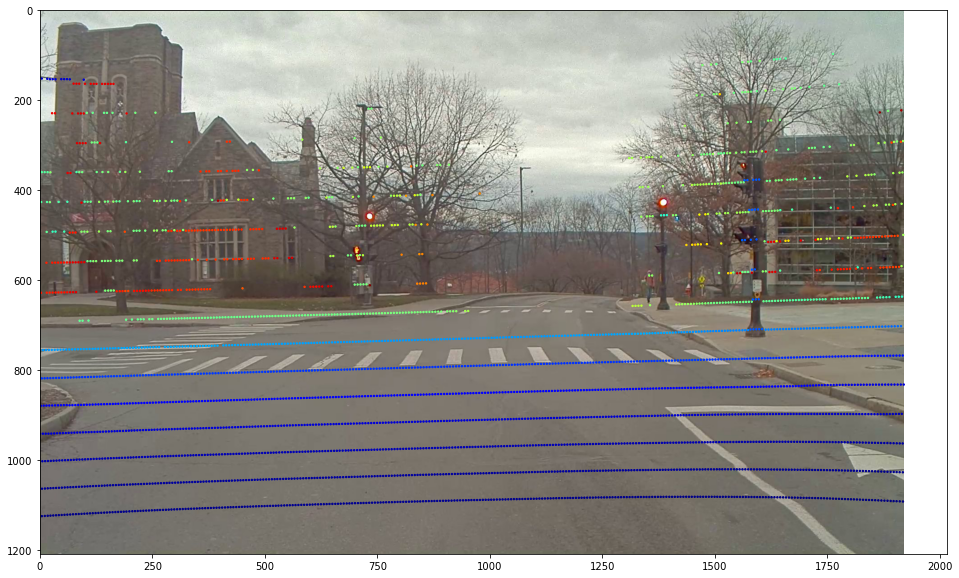

In [30]:
idx_match = np.argmin(abs(np.asarray(img_ts) - time_lidar))
img_file = os.path.split(img_files[0])[0] + '/' + str(img_ts[idx_match]) + '.jpg'
cmap = cm.get_cmap('jet')

img = plt.imread(img_file)
plt.figure(figsize = (150,10))
plt.imshow(img)
plt.scatter(u,v, s = 2, c=pts_infront[:,2],cmap = cmap)

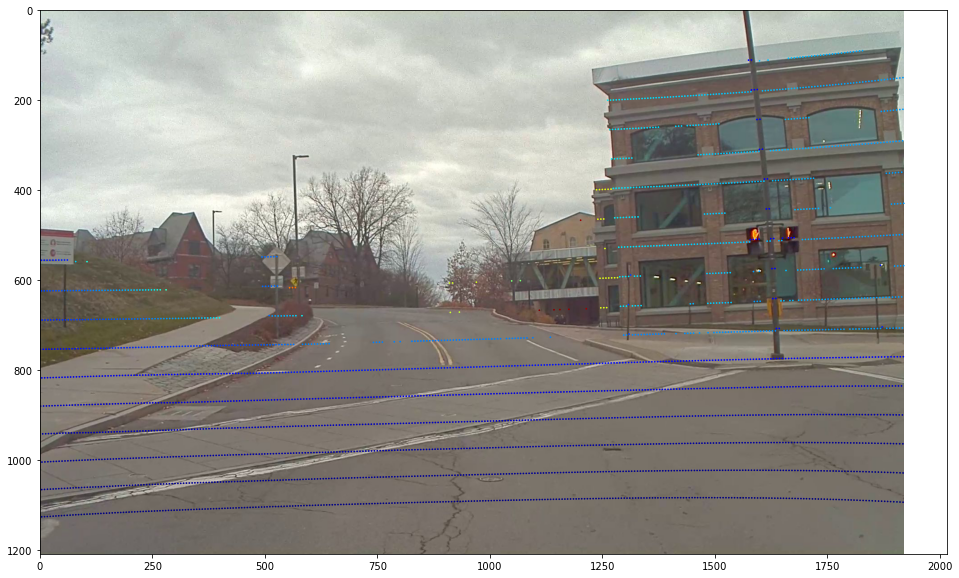

In [20]:
idx_match = np.argmin(abs(np.asarray(img_ts) - time_lidar))
img_file = os.path.split(img_files[0])[0] + '/' + str(img_ts[idx_match+1]) + '.jpg'
cmap = cm.get_cmap('jet')

img = plt.imread(img_file)
plt.figure(figsize = (150,10))
plt.imshow(img)
plt.scatter(u,v, s = 0.5, c=pts_infront[:,2],cmap = cmap)

In [26]:
img_file

'/home/xc429/Junan/calib_test/data2/cache/camera_front_left_60fov/1607111874001474.jpg'

In [27]:
lidar_files[idx]

'/home/xc429/Junan/calib_test/data2/cache/lidar_203/data/1607111873997399'

In [27]:
img_file

array([-0.03824922, -0.10691958,  0.16173619])

In [ ]:
1607111874007741.5
1607111874012713.8
1607111874016816.8